In [1]:
import argparse
import sys
import os
import random
import time
import re
import copy
import pickle
import pandas as pd
import numpy as np

import gc
import torch
from torch import nn, optim, cuda
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, \
                             TensorDataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import KFold

In [2]:
# from tqdm import tqdm|

from renet2.raw import load_documents
from renet2.raw_handler import *
from renet2.model import *

/autofs/bal31/jhsu/home/git/tmp/RENET2_b1/src/renet2/raw_handler.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from renet2.train_renet2_ft_cv import *

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.argv = ['']

if __name__ == "__main__":
    # set up
    parser = init_self_parser()
    args = parser.parse_args()
    
    sys.path.insert(0, 'renet2')
    get_index_path(args)
    
    
    use_cuda = torch.cuda.is_available() and not args.no_cuda
    device = torch.device('cuda' if use_cuda else 'cpu')
    torch.manual_seed(args.seed)

    if use_cuda:
        torch.cuda.manual_seed(args.seed)
    set_seed(args)
    args.device = device
    print('using device', device)

    args.ori_tokenizer = loading_tokenizer(args)
    args.token_voc_l = len(args.ori_tokenizer)
    print('tokenizer size %d' % (args.token_voc_l))
    
    print('fix input sentences# %d, tokens# %d, batch size %d' % (args.fix_snt_n, args.fix_token_n, args.batch_size))

using device cpu
loading word index from /autofs/bal31/jhsu/home/git/tmp/RENET2_b1/src/renet2/utils/word_index
loaded word index, voc size 82948
tokenizer size 82949
fix input sentences# 400, tokens# 54, batch size 60


In [18]:
args.raw_data_dir = '../data/raw_data/ft/T3/'

In [19]:
old_data_dir = args.annotation_info_dir
s_df = pd.read_csv(os.path.join(old_data_dir, "ft_500_n.tsv"), sep = '\t')

print('annotated table shape', s_df.shape)
# s_df = s_df[(s_df['hit_cnt_1k'] >= 3) | ~(s_df['Ann error (GD/ikrm)'] == 1)]
s_df = s_df[s_df['2nd_label'] != 0][['pmid', 'geneId', 'diseaseId', '2nd_label']]
s_df.rename(columns={'2nd_label':'label'}, inplace=True)

new_label_f_n = 'labels_n.txt'
s_df.to_csv(args.raw_data_dir + new_label_f_n, sep=',', index=False)

args.label_f_name = 'labels_n.txt'

annotated table shape (1556, 26)


In [20]:
# read data
print('reading input at {}'.format(args.raw_data_dir))

args.overwrite_cache = True

start_time = time.time()
features_ft_sub = load_and_cache_data(args)
dataset_ft_sub, _, _ = convert_features_to_dataset_single(features_ft_sub)
dataloader_ft_sub = DataLoader(dataset_ft_sub, batch_size=args.batch_size)
print("--- %.3f seconds ---" % (time.time() - start_time))


reading input at ../data/raw_data/ft/T3/
No cached file ../data/raw_data/ft/T3/cached_all_doc_0_400_54
Creating features from dataset file at  ../data/raw_data/ft/T3/
reading files docs.txt,sentences.txt,anns_n.txt,labels_n.txt
load data in path ../data/raw_data/ft/T3/docs.txt
*** Example ***                      
unique_id: 16963499
pairs 10 doc snt num 36
token string: [13] characterization of (['<54487>'], ['DGCR8']) (['<54487>'], ['Pasha']) the essential cofactor for (['<29102>'], ['Drosha']) in primary mirna processing
token ids   : [13] 1618 2 69929 69929 1 530 6954 9 40749 4 426 13 2149
fix feature : [13] 0 0 5 5 0 0 0 0 2 0 0 0 0
token string: [27] (['<54487>'], ['DGCR8']) (['<54487>'], ['Pasha']) is an essential cofactor for (['<29102>'], ['Drosha']) a nuclear rnase iii that cleaves the local hairpin structures embedded in long primary microrna transcripts pri-mirnas in eukaryotes
token ids   : [27] 69929 69929 16 29 530 6954 9 40749 6 889 20168 961 14 19718 1 2099 14287 3682 

In [21]:
# get the ABS model performance

# tar_path = os.path.join(old_data_dir, "full-text_sub_set_500_a_2nd.tsv")
tar_path = os.path.join(old_data_dir, "ft_500_n.tsv")
s_df = pd.read_csv(tar_path, sep = '\t')
# s_df = s_df[(s_df['hit_cnt_1k'] >= 3) | ~(s_df['Ann error (GD/ikrm)'] == 1)]

s_df['pmid'] = s_df['pmid'].astype(str)
s_df['geneId'] = s_df['geneId'].astype(str)
s_df['diseaseId'] = s_df['diseaseId'].astype(str)
s_df.rename(columns={'2nd_label':'new_label'}, inplace=True)

# annotated GDA
abs_s_df = s_df[['pmid', 'geneId', 'diseaseId', 'new_label']].copy()
abs_s_df_ner = s_df[['pmid', 'geneId', 'diseaseId', 'is_ner_error']].copy()
# abs_s_df['abs_label'] = abs_s_df.apply(lambda x: x['new_label'] if x['hit_cnt_1k']>=3 else 0, axis = 1)

# get the annotated GDA for model training
n_features_ft_sub = get_ann_dataset(features_ft_sub, abs_s_df)
N_ann_positive = len(n_features_ft_sub[1][n_features_ft_sub[1]['label']==1])
N_ann_all = len(n_features_ft_sub[1])
print(N_ann_positive, N_ann_all)

887 1489


In [22]:
# annotated non-NER errors GDA
_s_df = s_df[ (s_df['is_ner_error'].isna())]
_abs_s_df = _s_df[['pmid', 'geneId', 'diseaseId', 'new_label']].copy()

ner_error_df = s_df[ ~(s_df['is_ner_error'].isna())]
ner_error_df = ner_error_df[['pmid', 'geneId', 'diseaseId']].copy()

In [23]:
# reading BeFree and DT-Miner
global BeFree_df, DTMiner_df, BioBERT_df


In [24]:
# reading BeFree GDA
# _f = os.path.join(old_data_dir, "classification_result_befree.txt")
# gdas = pd.read_csv(_f, sep=',')
befree_f = '../benchmark/BeFree/n_out/classification_result_befree.txt'
gdas = pd.read_csv(befree_f, sep=',')
predicted_positive = gdas.drop_duplicates(['pmid', 'geneId', 'diseaseId'])
BeFree_df = predicted_positive[['pmid', 'geneId', 'diseaseId']].copy()
BeFree_df = set_df_to_str(BeFree_df)
BeFree_df['is_befree'] = 1
#print(BeFree_df.shape, BeFree_df.head(3))

# reading DTMiner GDA
# _f = os.path.join(old_data_dir, "classification_result_dtminer.txt")
# gdas = pd.read_csv(_f, sep=',')

dtminer_f = '../benchmark/DTMiner/n_out/classification_result_dtminer.txt'
gdas = pd.read_csv(dtminer_f, sep=',')
predicted_positive = gdas.drop_duplicates(['pmid', 'geneId', 'diseaseId'])
DTMiner_df = predicted_positive[['pmid', 'geneId', 'diseaseId']].copy()
DTMiner_df = set_df_to_str(DTMiner_df)
DTMiner_df['is_dtminer'] = 1
#print(DTMiner_df.shape, DTMiner_df.head(3))
print('get BeFree and DT-Miner data, shape', BeFree_df.shape, DTMiner_df.shape)

get BeFree and DT-Miner data, shape (3497, 4) (4201, 4)


In [25]:
# # read gene/disease id
# gdas = []
# with open("../benchmark/BeFree/n_out/cooc.befree") as f:
#     for line in f:
#         items = line.strip().split('\t')
#         gdas.append([int(items[0].split('|')[0]),"F", items[9], items[9], int(items[7].split('|')[0]), items[10], items[11], items[13], items[16], items[17], items[19]])
# gdas_befree = pd.DataFrame(np.array(gdas), columns=["GAD_ID","GAD_ASSOC","GAD_GENE_SYMBOL","GAD_GENE_NAME","GAD_ENTREZ_ID","NER_GENE_ENTITY","NER_GENE_OFFSET","GAD_DISEASE_NAME","NER_DISEASE_ENTITY","NER_DISEASE_OFFSET","GAD_CONCLUSION"])
# gdas_befree.GAD_ID = gdas_befree.GAD_ID.astype(int)
# gdas_befree.GAD_ENTREZ_ID = gdas_befree.GAD_ENTREZ_ID.astype(int)

# gdas_for_biobert = gdas_befree  
# gdas_for_biobert = gdas_for_biobert[['GAD_ID', 'GAD_ENTREZ_ID', 'GAD_DISEASE_NAME']].copy()
# gdas_for_biobert = gdas_for_biobert.rename(columns={"GAD_ID": "pmid", "GAD_ENTREZ_ID": "geneId", \
#                                                    "GAD_DISEASE_NAME": "diseaseId"})

# # read true label
# true_pd = pd.read_csv('../benchmark/test.tsv', sep='\t', index_col=0)

# bert_f = '../benchmark/re_outputs_1/test_results.tsv'
# pred_df = pd.read_csv(bert_f, sep='\t', header=None)
# pred_df['pred'] = pred_df.apply(lambda x: 1 if x[1] > 0.5 else 0, axis = 1)

# gdas_for_biobert['label'] = true_pd['label']
# gdas_for_biobert['pred'] = pred_df['pred']
# predicted_positive = gdas_for_biobert[gdas_for_biobert.pred==1][['pmid', 'geneId', 'diseaseId']].drop_duplicates()

# predicted_positive.to_csv("classification_result_biobert.txt", index=False, columns=['pmid', 'geneId', 'diseaseId'])

# actual_positive = gdas_for_biobert[gdas_for_biobert['label'] == 1][['pmid', 'geneId', 'diseaseId']].drop_duplicates()
# print(actual_positive.shape)
# print(predicted_positive.shape)

In [26]:
# actual_positive

In [27]:
# actual_positive = set_df_to_str(actual_positive)
# actual_positive_t = actual_positive.copy()
# actual_positive_t['label'] = 1
# tmp = abs_s_df[abs_s_df['new_label'] == 1].merge(actual_positive_t, on=['pmid', 'geneId', 'diseaseId'], how='left')

In [28]:
# d = {}

In [29]:
# g_n_d = {'DGCR8': {'54487'}, 'Pasha': {'54487'}, 'Drosha': {'29102'}, 'miR-17': {'723905'}, 'RNase III': {'29102'}, 'exportin-5': {'57510'}, 'Exp5': {'57510'}, 'Dicer': {'23405'}, 'Rsp5': {'23327'}, 'miR-16-1': {'406950'}, 'DG1': {'1828'}}
# g_id_d = {'54487': {'DGCR8', 'Pasha'}, '29102': {'RNase III', 'Drosha'}, '723905': {'miR-17'}, '57510': {'exportin-5', 'Exp5'}, '23405': {'Dicer'}, '23327': {'Rsp5'}, '406950': {'miR-16-1'}, '1828': {'DG1'}} 

In [30]:
# hit_t = {
#     #id: times
# }

# sort_orders = sorted(orders.items(), key=lambda x: x[1], reverse=True)

# g_id_m = {}

# for k, v in g_id_d:
#     if k in g_id_m:
#         continue
#     _id_s, _name = {k}, v
#     while True:
#         _tmp_id_s = set()
#         for _n in name:
#             _tmp_id = g_n_d[_n]
#             _tmp_id_s = _tmp_id_s | _tmp_id
#         if _tmp_id_s == _id_s:
#             break
#         else:
#             _id_s = _id_s | _tmp_id_s
#     _tmp_hit_t = {i: hit_i[i] for i in _id_s}
#     tar_id = sorted(_tmp_hit_t.items(), key=lambda x: x[1], reverse=True)[0][0]
#     print(sorted(_tmp_hit_t.items(), key=lambda x: x[1], reverse=True))
#     for _id in _id_s:
#         g_id_m[_id] = tar_id

In [31]:
biobert_f = '../benchmark/classification_result_biobert.txt'
gdas = pd.read_csv(biobert_f, sep=',')
predicted_positive = gdas.drop_duplicates(['pmid', 'geneId', 'diseaseId'])
BioBERT_df = predicted_positive[['pmid', 'geneId', 'diseaseId']].copy()
BioBERT_df = set_df_to_str(BioBERT_df)
BioBERT_df['is_biobert'] = 1

In [32]:
print('get BeFree, DT-Miner, and BioBERT data, shape', BeFree_df.shape, DTMiner_df.shape, BioBERT_df.shape)

get BeFree, DT-Miner, and BioBERT data, shape (3497, 4) (4201, 4) (4598, 4)


In [33]:
# BeFree_df, DTMiner_df = None, None
def evaluate_rst_all_info(ori_df, ori_c, ann_df, is_freeze_c = False, b_ann_df = False):
    global BeFree_df, DTMiner_df, BioBERT_df
    
    if not is_freeze_c:
        global ReNet_df

    _rst = []
    _df = ori_df.copy()
    _c = ori_c
    if not is_freeze_c:
        _c = 'pred_tmp'
        _df.rename(columns={ori_c:'pred_tmp'}, inplace=True)

    # predicted GDA
    _pred_N = sum(_df[_c])
    _rst.append(_pred_N)

    # precision on ann & based #
    S1 = get_scores_a(_df, _c, ann_df, 'new_label')
    _precision1, _recall, N_ann = S1
    _rst.extend([_precision1])

    # merging renet|befree|dtminer result first
    if not is_freeze_c:
        merge_t_df = _df.merge(BeFree_df, on=['pmid', 'geneId','diseaseId'], how='outer')
    else:
        merge_t_df = ReNet_df.merge(BeFree_df, on=['pmid', 'geneId','diseaseId'], how='outer')
        
    merge_t_df = merge_t_df.merge(DTMiner_df, on=['pmid', 'geneId','diseaseId'], how='outer')
    merge_t_df = merge_t_df.merge(BioBERT_df, on=['pmid', 'geneId','diseaseId'], how='outer')
    merge_t_df = merge_t_df.fillna(0)
    ann_positive = ann_df.copy()
    
    df=merge_t_df
    F=[1,1,1,1]
    c=[_c,'is_dtminer','is_befree','is_biobert']
#     print(c)
    if is_freeze_c:
        c=['is_renet','is_dtminer','is_befree','is_biobert']
    
    # c[0], c[2] = c[2], c[0]
    mdl_positive = df[(df[c[0]]==F[0]) & ((df[c[1]]==F[1]) & (df[c[2]]==F[2]) & (df[c[3]]==F[3]))]
    
    if isinstance(b_ann_df, pd.DataFrame):
        mdl_positive = b_ann_df.merge(mdl_positive, on=['pmid', 'geneId','diseaseId'], how='outer')
        mdl_positive = mdl_positive[mdl_positive['is_ner_error'].isna()]
        del mdl_positive['is_ner_error']
        
    olp_positive = ann_positive.merge(mdl_positive, on=['pmid', 'geneId','diseaseId'], how='outer')
    
    ann_n, mdl_n, olp_n = len(ann_positive), len(mdl_positive), len(olp_positive)
#     print('---', ann_n, mdl_n, olp_n)
    
#     print('model confidence GDA {}, adding {} to TP, total TP {}'.format(mdl_n, olp_n-ann_n, olp_n))
#     print(olp_positive.head(3))
    
    olp_positive['ann_label'] = olp_positive['new_label']
    olp_positive['ann_label'] = olp_positive['ann_label'].fillna(0)
    olp_positive = olp_positive[['pmid', 'geneId','diseaseId', 'new_label', 'ann_label']]
    olp_positive['new_label'] = olp_positive['new_label'].fillna(1)
    olp_positive.shape
    targe_df = merge_t_df.merge(olp_positive, on=['pmid', 'geneId','diseaseId'], how='left')
    targe_df['new_label'] = targe_df['new_label'].fillna(0)

    tar_df = _df.copy()
    if isinstance(b_ann_df, pd.DataFrame):
        tar_df = tar_df.merge(b_ann_df, on=['pmid', 'geneId','diseaseId'], how='left')
        tar_df['pred'] = tar_df.apply(lambda x: 1 if x[_c] ==1 and pd.isnull(x['is_ner_error']) else 0, axis=1)
    else:
        tar_df['pred'] = _df.apply(lambda x: 1 if x[_c] ==1 else 0, axis=1)
    S2 = get_scores_a(tar_df, 'pred', targe_df, 'new_label')
    _precision2, _, N_p2 = S2
#     print(S2)
    _rst.extend([_precision2])



    _rst.append(_recall)
#     print(','.join(list(map(str, _rst))))
    return _rst

def evaluate_rst_all_info_err(ori_df, ori_c, ann_df, _ann_df, abs_s_df_ner, is_freeze_c = False):
    _rst1 = evaluate_rst_all_info(ori_df, ori_c, ann_df, is_freeze_c)
    
    _rst2 = evaluate_rst_all_info(ori_df, ori_c, _ann_df, is_freeze_c, abs_s_df_ner)
#     _rst = _rst1[0], _rst1[1], _rst2[1], _rst1[2], _rst2[2], _rst1[4], _rst2[4], _rst1[6], _rst2[6]
#     _rst = _rst1[0], _rst1[2], _rst2[2], _rst1[4], _rst2[4], _rst1[6], _rst2[6]
    _rst = _rst1[0], _rst1[2], _rst2[2], _rst1[3], _rst2[3]
#     _rst = _rst1, _rst2
    return _rst

In [35]:
_sida_base_dir = args.annotation_info_dir

In [36]:
print('get the result of the RENET2 trained based models, prepared for [enhanced data]')
m_df = 0
s_arr = []
for _i in range(10):
#     old_data_dir = '../data/ft_info'
#     cls_file = os.path.join(old_data_dir, "ft_base_model_rst/ft_rst_ann_2nd_%02d.tsv" % (_i+1))
    cls_file = os.path.join(_sida_base_dir, "cls_rst/ft_base_dev_%02d.tsv" % (_i+1))

    y_info = pd.read_csv(cls_file, sep='\t')
    y_info['pmid'] = y_info['pmid'].astype(str)
    y_info['geneId'] = y_info['geneId'].astype(str)
    y_info['diseaseId'] = y_info['diseaseId'].astype(str)
    y_info['label'] = y_info['label'].astype(str)

    S = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df, _abs_s_df, abs_s_df_ner)
#     print(S)
    s_arr.append(list(S))

    y_info.rename(columns={'pred':'pred_%02d'%(_i+1)}, inplace=True)
#     y_info = y_info[y_info['pred'] == 1]
    m_df = y_info if _i == 0 else m_df.merge(y_info, on=['pmid', 'geneId','diseaseId', 'label'], how='outer')


m_df['hit_cnt'] = m_df.apply(lambda x: sum([x['pred_%02d'%(_i+1)] for _i in range(10)]), axis=1)
ori_m_df = m_df.copy()
s_arr = np.array(s_arr)

print('10X modes\' positive #, precision, precision[-], recall, recall[-]')
for r in s_arr:
    print(','.join([str(i) for i in r]))

avg_l = list(np.mean(s_arr, axis=0))
avg_l = ['avg'] + avg_l

print(','.join(list(map(str, avg_l))))

print('assemble, positive #, precision, precision[-], recall, recall[-]')
for _i in range(1, 11):
    ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
    ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= _i else 0, axis=1)

    _rst = evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner)
    _rst = [_i] + list(_rst)
    print(','.join(list(map(str, _rst))))

the_p_cnt = 5
ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= the_p_cnt else 0, axis=1)

print('selected assemble models at {}+, shape {}, result:'.format(the_p_cnt, ReNet_df.shape))
print(evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner))

get the result of the RENET trained based models, prepared for [enhanced data]
10X modes' positive #, precision, precision[-], recall, recall[-]
1183.0,0.6545914069081719,0.7348790322580645,0.7181208053691275,0.7251908396946565
1333.0,0.6237845923709798,0.6971580817051509,0.7751677852348994,0.7888040712468194
1149.0,0.6617519514310495,0.7497371188222923,0.7293064876957495,0.7353689567430025
1258.0,0.6394611727416799,0.7157794676806084,0.7416107382550335,0.7442748091603053
1403.0,0.6382373845060412,0.7108843537414966,0.8154362416107382,0.8180661577608143
1235.0,0.6448748991121872,0.7255092143549952,0.761744966442953,0.7709923664122137
1184.0,0.6717171717171717,0.755,0.7293064876957495,0.7442748091603053
1130.0,0.691358024691358,0.7864184008762322,0.7639821029082774,0.7544529262086515
1252.0,0.6648089171974523,0.741904761904762,0.743847874720358,0.7442748091603053
1229.0,0.6593673965936739,0.7448275862068966,0.7706935123042505,0.7735368956743003
avg,1235.6,0.6549952917269766,0.7362098017

In [37]:
m_df = ori_m_df.copy()

In [38]:
the_p_cnt = 1
ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= the_p_cnt else 0, axis=1)

print('selected assemble models at {}+, shape {}, result:'.format(the_p_cnt, ReNet_df.shape))
print(evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner))

selected assemble models at 1+, shape (13641, 4), result:
(2208, 0.566003616636528, 0.6107660455486542, 0.9272930648769575, 0.9325699745547074)


In [39]:
_rst = evaluate_rst_all_info(BeFree_df, 'is_befree', abs_s_df, is_freeze_c=True)
print(','.join(list(map(str, _rst))))

_rst = evaluate_rst_all_info(DTMiner_df, 'is_dtminer', abs_s_df, is_freeze_c=True)
print(','.join(list(map(str, _rst))))

_rst = evaluate_rst_all_info(BioBERT_df, 'is_biobert', abs_s_df, is_freeze_c=True)
print(','.join(list(map(str, _rst))))

3497,0.7927519818799547,0.32085714285714284,0.7829977628635347
4201,0.8104712041884817,0.2846611177170036,0.8657718120805369
4598,0.7953216374269005,0.2692307692307692,0.912751677852349


In [40]:
merge_t_df = ReNet_df.merge(BeFree_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(DTMiner_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(BioBERT_df, on=['pmid', 'geneId','diseaseId'], how='outer')

merge_t_df = merge_t_df.fillna(0)

F=[1,1,1,1]
c=['is_renet','is_dtminer','is_befree','is_biobert']

df = merge_t_df
m_df = df[(df[c[0]]==F[0]) | ((df[c[1]]==F[1]) | (df[c[2]]==F[2]) | (df[c[3]]==F[3]))]

In [41]:
m_df

,pmid,geneId,diseaseId,is_renet,is_befree,is_dtminer,is_biobert
0,17579508,30818,D012559,1.0,0.0,0.0,0.0
1,10579720,109676,D009135,1.0,1.0,1.0,1.0
2,10579720,109676,D009140,1.0,1.0,1.0,1.0
3,10579720,109676,D007738,1.0,1.0,1.0,1.0
4,10579720,109676,D009224,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
13642,32313880,5879,D005355,0.0,1.0,0.0,1.0
13643,25965909,24148,D004194,0.0,1.0,0.0,1.0
13644,30571509,114548,D007239,0.0,1.0,1.0,1.0
13645,30571509,3553,D007239,0.0,1.0,1.0,1.0


In [42]:
rst_idx = []
rst_idx.append(list(m_df[m_df[c[0]] == 1].index))
rst_idx.append(list(m_df[m_df[c[1]] == 1].index))
rst_idx.append(list(m_df[m_df[c[2]] == 1].index))
rst_idx.append(list(m_df[m_df[c[3]] == 1].index))

In [43]:
%matplotlib inline

from utils import venn

In [ ]:
labels = venn.get_labels(rst_idx, fill=['number'])
fig, ax = venn.venn4(labels, names=['RENET2', 'BeFree', 'DTMiner', 'BioBERT'])
fig.show()

In [45]:
print('get enhanced data')

# addon_olp3p_feature = get_addon_data_ft(features_ft_sub, mdl_df, -1, 1, False)
# merging renet|befree|dtminer result first
merge_t_df = ReNet_df.merge(BeFree_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(DTMiner_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(BioBERT_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df[~merge_t_df.is_renet.isnull()]
merge_t_df = merge_t_df.fillna(0)

F=[0, 0, 0, 0] #all negative
# F=[1, 1, 1] #all positive
c=['is_renet','is_dtminer','is_befree', 'is_biobert']
df = merge_t_df
mdl_df = df[(df[c[0]]==F[0]) & ((df[c[1]]==F[1]) & (df[c[2]]==F[2]) & (df[c[3]]==F[3]))].copy()
mdl_df['is_tar'] = 1

# opt 1 filter the GDA annotated
mdl_df = mdl_df.merge(abs_s_df, how='left')
mdl_df = mdl_df[mdl_df.new_label.isnull()]
mdl_df_n = mdl_df[['pmid', 'geneId','diseaseId', 'is_tar']].copy()

N_ann_positive = len(n_features_ft_sub[1][n_features_ft_sub[1]['label']==1])
N_ann_all = len(n_features_ft_sub[1])
#print(N_ann_positive, N_ann_all)
# N_ann_positive += len(addon_olp3p_feature[1])
add_to_rate = 2
N_add_nan = int(N_ann_positive * add_to_rate - N_ann_all)
# N_add_nan = int(500 * (5/4))
print(N_ann_positive, N_ann_all, N_add_nan, 100.*N_add_nan/N_ann_positive, N_add_nan+N_ann_all)
addon_nan_feature = get_addon_data_ft(features_ft_sub, mdl_df_n, N_add_nan, 0, True)


# reading pmid list, for CV
_f = os.path.join(old_data_dir, 'PMID_lst')
with open(_f, 'rb' ) as fp:
    PMID_lst = pickle.load(fp)
#len(PMID_lst), PMID_lst[:3]


get enhanced data
887 1489 285 32.13077790304397 1774


In [47]:
args.raw_data_dir

'../data/raw_data/ft/T3/'

In [46]:
def run_dev():
    IS_DEBUG = False
    IS_RUN_1 = False
    IS_ADD_FT_N = False
    IS_ADD_FT_P = False


    _start_time = time.time()


    # testing ann
    tar_feature = n_features_ft_sub
    all_feature = features_ft_sub

    add_feature_n = addon_nan_feature if IS_ADD_FT_N else None
    add_feature_p = addon_olp3p_feature if IS_ADD_FT_P else None

    run_cls_df_l = []
    adj_arr = []
    ori_arr = []
    kf = KFold(n_splits=5)


    for idx, (train_pmid_lst_i, test_pmid_lst_i) in enumerate(kf.split(PMID_lst)):
    #     if idx < 3:
    #         continue
        print("CV run %s/5" % (idx+1))
    #     print(len(train_pmid_lst_i), train_pmid_lst_i[:3])
        #print(len(test_pmid_lst_i), test_pmid_lst_i[:3])

        train_pmid_lst = [PMID_lst[i] for i in train_pmid_lst_i]
        test_pmid_lst = [PMID_lst[i] for i in test_pmid_lst_i]

        train_index = tar_feature[1][(tar_feature[1].pmid.isin(train_pmid_lst))].index
        test_index = tar_feature[1][(tar_feature[1].pmid.isin(test_pmid_lst))].index

        _train_dev_ds, _test_ds = convert_features_to_dataset_cv(tar_feature, train_index), \
                                convert_features_to_dataset_cv(tar_feature, test_index)

        if IS_ADD_FT_N:
            #add data in training dataset
            add_feature = add_feature_n
            add_index = add_feature[1][(add_feature[1].pmid.isin(train_pmid_lst))].index
            #print('using add feature: %s' % len(add_index))
            add_dataset = convert_features_to_dataset_cv(add_feature, add_index)
            _train_dev_ds = torch.utils.data.ConcatDataset([_train_dev_ds, add_dataset]) 

        if IS_ADD_FT_P:
            #add data in training dataset
            add_feature = add_feature_p
            add_index = add_feature[1][(add_feature[1].pmid.isin(train_pmid_lst))].index
            #print('using add feature: %s' % len(add_index))
            add_dataset = convert_features_to_dataset_cv(add_feature, add_index)
            _train_dev_ds = torch.utils.data.ConcatDataset([_train_dev_ds, add_dataset]) 

        train_dataloader_ds = DataLoader(_train_dev_ds, batch_size=args.batch_size, shuffle=True)
        print('training dataset size {}'.format(len(_train_dev_ds)))


    #     train_dataloader_ds = DataLoader(_train_dev_ds, batch_size=args.batch_size)
        test_dataloader_ds = DataLoader(_test_ds, batch_size=args.batch_size)

        train_dt, dev_dt, test_dt = train_dataloader_ds, None, test_dataloader_ds

        n_test_index = all_feature[1][(all_feature[1].pmid.isin(test_pmid_lst))].index
        n_test_ds = convert_features_to_dataset_cv(all_feature, n_test_index)
        n_test_dt = DataLoader(n_test_ds, batch_size=args.batch_size)


        # loading pretrained abstract model
        #args.modle_dir = '../models/'
        #model_name_prefix = 'Bst_abs_10'

        #print('loading based model from', model_name_prefix)
        #checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
        #config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

        checkpoint_f = os.path.join(args.pretrained_model_p + ".ckp")
        config_save_f = os.path.join(args.pretrained_model_p + ".cf")

        config = torch.load(config_save_f)
        model, _, _ = load_checkpoint(config, checkpoint_f)


        # model config
        args.EB_dp = 0.3
        args.FC_dp = 0.1

        # training config
        args.use_new_loss = False
        args.use_cls_loss = False


        #args.epochs = 10
        #args.epochs = 1
        args.warmup_epoch = 0
        args.patience_epoch = 3

        args.learning_rate = args.lr
        #args.learning_rate = 8e-4
        args.weight_decay = 8e-6
        args.l2_weight_decay = 5e-5
        args.max_grad_norm = 2.0
        args.lr_reduce_factor = 0.5
        args.lr_cooldown = 0
        args.threshold = .5
        args.adam_epsilon = 1e-8
        args.use_loss_sh = False
#         args.is_iterare_info = not IS_DEBUG
        args.is_iterare_info = True


        args.device = device


        config = update_model_config(args, config, False)

        model.update_model_config(config)

#         if torch.cuda.device_count() > 1:
#             print("use", torch.cuda.device_count(), "GPUs!")
#             model = nn.DataParallel(model)

        model.to(device)
        optimizer, scheduler = init_model_optimizer(model, args)
        scheduler.step(0)

        is_save_new_train = False
#         args.modle_dir = '../models'
        args.modle_dir = args.raw_data_dir
        model_name_prefix = 'build_ft_base'

        args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
        args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")
        if is_save_new_train:
            torch.save(config, args.config_save_f)

        if IS_DEBUG:
            print("testing------")

            pred_l, tru_l, S, pred_o = eval(model, n_test_dt, args, 'test')
            y_info = all_feature[1].iloc[n_test_index].copy()
            y_info['pred'] = pred_l
            _rst = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df[(abs_s_df.pmid.isin(test_pmid_lst))], _abs_s_df, abs_s_df_ner)
            Tar_l = list(_rst) + list(S[1:4]) 
            print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), Tar_l)))
            ori_arr.append(Tar_l[:])

        print("training------")

        _, _, S_ori, _ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt, is_save_new_train)

        pred_l, tru_l, S, pred_o = eval(model, n_test_dt, args, 'test')
        y_info = all_feature[1].iloc[n_test_index].copy()
        y_info['pred'] = pred_l
        y_info['prob'] = pred_o
        _rst = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df[(abs_s_df.pmid.isin(test_pmid_lst))], _abs_s_df, abs_s_df_ner)
        Tar_l = list(_rst) + list(S_ori[1:4])
        print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), Tar_l)))

        run_cls_df_l.append(y_info)
        adj_arr.append(Tar_l[:])

        model = None
        if not args.no_cuda:
            free_cuda()
        print("*********")

        if IS_RUN_1:
            break

    print('CV end')


    if IS_DEBUG:
        ori_arr = np.array(ori_arr)

        for r in ori_arr:
            print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), r)))

        print('---')

    adj_arr = np.array(adj_arr)

    for r in adj_arr:
        print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), r)))


    print('CV mean, positive #, precision, precision[-], recall, recall[-]')
    print(list(np.mean(adj_arr, axis=0)))
    print('mlt train ended')


    mer_pd_rst = pd.concat(run_cls_df_l)

    _rst = evaluate_rst_all_info_err(mer_pd_rst, 'pred', abs_s_df, _abs_s_df, abs_s_df_ner)
    print('CV merge, positive #, precision, precision[-], recall, recall[-]')
    print(','.join(list(map(str, _rst))))

    print("--- %s seconds ---" % (time.time() - _start_time))   
    return _rst, mer_pd_rst


In [48]:

start_time = time.time()
# RST = run_dev()

all_RST = []

for _i in range(1, 11):
#     continue
    print('****\nbegin training 10X RENET2 models {}\n'.format(_i))
    RST = run_dev()
    all_RST.append(RST)
    mer_pd_rst = RST[1]
#     cls_rst_file = os.path.join(args.raw_data_dir, "ft_rst_ann_2nd_dev_exp_w%d_%02d.tsv" % (IG_N, _i))

    cls_rst_file = os.path.join(args.raw_data_dir, "ft_base_%02d.tsv" % (_i))
    mer_pd_rst.to_csv(cls_rst_file, sep='\t', index=False)
    print('rst at {}'.format(cls_rst_file))
    #break
print("--- %s seconds ---" % (time.time() - start_time))

****
begin training 10X RENET2 models 1

CV run 1/5
training dataset size 1219
training------
training begin
e_1 * test rst: [0.00435, 0.5889, 0.9551, 0.7286, 0.6435]
e_2 * test rst: [0.00423, 0.6683, 0.8526, 0.7493, 0.6526]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00432, 0.6135, 0.8141, 0.6997, 0.6325]
e_4 * test rst: [0.00443, 0.6327, 0.9167, 0.7487, 0.6537]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00462, 0.6226, 0.6346, 0.6286, 0.6319]
e_6 * test rst: [0.00456, 0.6620, 0.6026, 0.6309, 0.6447]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00444, 0.6364, 0.8077, 0.7119, 0.6522]
e_8 * test rst: [0.00449, 0.6349, 0.7692, 0.6957, 0.6307]
Epoch     8: reducing learning rate of group 0 to 5.000

e_5 * test rst: [0.00427, 0.6435, 0.8910, 0.7473, 0.6775]
e_6 * test rst: [0.00498, 0.6481, 0.6731, 0.6604, 0.6200]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00484, 0.6310, 0.6795, 0.6543, 0.6251]
e_8 * test rst: [0.00501, 0.6531, 0.6154, 0.6337, 0.6177]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00473, 0.6374, 0.6987, 0.6667, 0.6326]
e_10 * test rst: [0.00488, 0.6369, 0.6859, 0.6605, 0.6275]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 203.13 s
190,0.66316,0.80882,0.68153,0.11578,0.63690,0.68590,0.66049
*********
CV run 2/5
training dataset size 1202
training------
training begin
e_1 * test rst: [0.00393, 0.7014, 0.8470, 0.7673, 0.6272]
e_2 * test rst: [0.00384, 0.7245, 0.7760, 0.7493, 0.674

300,0.60333,0.67220,0.74522,0.12468,0.66102,0.75000,0.70270
*********
CV run 2/5
training dataset size 1202
training------
training begin
e_1 * test rst: [0.00388, 0.6844, 0.9126, 0.7822, 0.6616]
e_2 * test rst: [0.00447, 0.7582, 0.6339, 0.6905, 0.6830]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00350, 0.7461, 0.7869, 0.7660, 0.7412]
e_4 * test rst: [0.00382, 0.7687, 0.6175, 0.6848, 0.7302]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00413, 0.7971, 0.6011, 0.6854, 0.7321]
e_6 * test rst: [0.00393, 0.7654, 0.7486, 0.7569, 0.7278]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00400, 0.7194, 0.7705, 0.7441, 0.7126]
e_8 * test rst: [0.00396, 0.7245, 0.7760, 0.7493, 0.7290]
Epoch     8: reducing lear

e_5 * test rst: [0.00378, 0.7170, 0.8306, 0.7696, 0.6804]
e_6 * test rst: [0.00398, 0.7044, 0.7814, 0.7409, 0.6736]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00401, 0.7310, 0.6831, 0.7062, 0.6895]
e_8 * test rst: [0.00412, 0.7317, 0.6557, 0.6916, 0.6764]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00411, 0.7168, 0.6776, 0.6966, 0.6781]
e_10 * test rst: [0.00423, 0.7308, 0.6230, 0.6726, 0.6758]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 201.78 s
202,0.68627,0.78919,0.61290,0.13740,0.73077,0.62295,0.67257
*********
CV run 3/5
training dataset size 1257
training------
training begin
e_1 * test rst: [0.00434, 0.6829, 0.4308, 0.5283, 0.5455]
e_2 * test rst: [0.00414, 0.5915, 0.7462, 0.6599, 0.625

268,0.67407,0.76132,0.76882,0.17048,0.71144,0.78142,0.74479
*********
CV run 3/5
training dataset size 1257
training------
training begin
e_1 * test rst: [0.00408, 0.6199, 0.8154, 0.7043, 0.6377]
e_2 * test rst: [0.00384, 0.6733, 0.7769, 0.7214, 0.7041]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00390, 0.6280, 0.7923, 0.7007, 0.7093]
e_4 * test rst: [0.00396, 0.6407, 0.8231, 0.7205, 0.7081]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00405, 0.6767, 0.6923, 0.6844, 0.7039]
e_6 * test rst: [0.00392, 0.6500, 0.8000, 0.7172, 0.7150]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00400, 0.6573, 0.7231, 0.6886, 0.7180]
e_8 * test rst: [0.00416, 0.6643, 0.7154, 0.6889, 0.7101]
Epoch     8: reducing lear

e_5 * test rst: [0.00359, 0.7407, 0.7692, 0.7547, 0.7603]
e_6 * test rst: [0.00361, 0.7313, 0.7538, 0.7424, 0.7582]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00365, 0.7308, 0.7308, 0.7308, 0.7572]
e_8 * test rst: [0.00365, 0.7259, 0.7538, 0.7396, 0.7624]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00373, 0.6918, 0.7769, 0.7319, 0.7575]
e_10 * test rst: [0.00376, 0.7197, 0.7308, 0.7252, 0.7575]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 208.33 s
199,0.66332,0.73743,0.73077,0.12087,0.71970,0.73077,0.72519
*********
CV run 4/5
training dataset size 1111
training------
training begin
e_1 * test rst: [0.00417, 0.6752, 0.7117, 0.6930, 0.6869]
e_2 * test rst: [0.00392, 0.6630, 0.8243, 0.7349, 0.725

285,0.54386,0.57692,0.77692,0.12214,0.66887,0.77692,0.71886
*********
CV run 4/5
training dataset size 1111
training------
training begin
e_1 * test rst: [0.00421, 0.6266, 0.8919, 0.7361, 0.6493]
e_2 * test rst: [0.00372, 0.6715, 0.8378, 0.7455, 0.7464]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00379, 0.7500, 0.7162, 0.7327, 0.7399]
e_4 * test rst: [0.00371, 0.7359, 0.7658, 0.7506, 0.7600]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00375, 0.7068, 0.7928, 0.7473, 0.7560]
e_6 * test rst: [0.00382, 0.7412, 0.7613, 0.7511, 0.7573]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00375, 0.7339, 0.7703, 0.7516, 0.7586]
e_8 * test rst: [0.00383, 0.7195, 0.7973, 0.7564, 0.7601]
Epoch     8: reducing lear

e_5 * test rst: [0.00385, 0.6567, 0.8874, 0.7548, 0.7747]
e_6 * test rst: [0.00383, 0.7554, 0.7928, 0.7736, 0.7755]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00394, 0.7214, 0.8514, 0.7810, 0.7704]
e_8 * test rst: [0.00388, 0.7679, 0.7748, 0.7713, 0.7746]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00393, 0.7555, 0.7793, 0.7672, 0.7767]
e_10 * test rst: [0.00399, 0.7439, 0.8243, 0.7821, 0.7742]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 190.44 s
307,0.68506,0.75000,0.82063,0.21247,0.74390,0.82432,0.78205
*********
CV run 5/5
training dataset size 1167
training------
training begin
e_1 * test rst: [0.00454, 0.6092, 0.7398, 0.6682, 0.5813]
e_2 * test rst: [0.00471, 0.6504, 0.8163, 0.7240, 0.624

256,0.74708,0.83333,0.76233,0.19975,0.77982,0.76577,0.77273
*********
CV run 5/5
training dataset size 1167
training------
training begin
e_1 * test rst: [0.00456, 0.6216, 0.7041, 0.6603, 0.5972]
e_2 * test rst: [0.00449, 0.6652, 0.7602, 0.7095, 0.6378]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00448, 0.6681, 0.7908, 0.7243, 0.6782]
e_4 * test rst: [0.00443, 0.6786, 0.8724, 0.7634, 0.6770]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00460, 0.6806, 0.7500, 0.7136, 0.6793]
e_6 * test rst: [0.00456, 0.6996, 0.8316, 0.7599, 0.6849]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00482, 0.6942, 0.7296, 0.7114, 0.6792]
e_8 * test rst: [0.00494, 0.7068, 0.6888, 0.6977, 0.6815]
Epoch     8: reducing lear

e_5 * test rst: [0.00479, 0.7044, 0.7296, 0.7168, 0.6615]
e_6 * test rst: [0.00476, 0.6537, 0.8571, 0.7417, 0.6413]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00466, 0.6468, 0.8878, 0.7484, 0.6478]
e_8 * test rst: [0.00489, 0.6426, 0.8622, 0.7364, 0.6451]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00478, 0.6610, 0.7959, 0.7222, 0.6589]
e_10 * test rst: [0.00485, 0.6523, 0.8520, 0.7389, 0.6440]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 197.41 s
465,0.48712,0.50919,0.84343,0.16285,0.65234,0.85204,0.73894
*********
CV end
203.0,0.67980,0.82877,0.79618,0.13740,0.66845,0.80128,0.72886
213.0,0.69302,0.79275,0.69355,0.15394,0.71667,0.70492,0.71074
227.0,0.61233,0.65672,0.77692,0.11959,0.64744,0.77

In [50]:
m_df = 0
s_arr = []
for _i in range(10):
    cls_file = os.path.join(args.raw_data_dir, "ft_base_%02d.tsv" % (_i+1))

    y_info = pd.read_csv(cls_file, sep='\t')
    y_info['pmid'] = y_info['pmid'].astype(str)
    y_info['geneId'] = y_info['geneId'].astype(str)
    y_info['diseaseId'] = y_info['diseaseId'].astype(str)
    y_info['label'] = y_info['label'].astype(str)

    S = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df, _abs_s_df, abs_s_df_ner)
#     print(S)
    s_arr.append(list(S))

    y_info.rename(columns={'prob':'prob_%02d'%(_i+1)}, inplace=True)
    y_info.rename(columns={'pred':'pred_%02d'%(_i+1)}, inplace=True)
#     y_info = y_info[y_info['pred'] == 1]
    m_df = y_info if _i == 0 else m_df.merge(y_info, on=['pmid', 'geneId','diseaseId', 'label'], how='outer')


m_df['hit_cnt'] = m_df.apply(lambda x: sum([x['pred_%02d'%(_i+1)] for _i in range(10)]), axis=1)

s_arr = np.array(s_arr)

print('10X #, positive #, precision, precision[-], recall, recall[-]')
for r in s_arr:
    print(','.join([str(i) for i in r]))


#print(list(np.mean(s_arr, axis=0)))


avg_l = list(np.mean(s_arr, axis=0))
avg_l = ['avg'] + avg_l

print(','.join(list(map(str, avg_l))))

print('assemble, positive #, precision, precision[-], recall, recall[-]')
for _i in range(1, 11):
    ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
    ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= _i else 0, axis=1)

    _rst = evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner)
    _rst = [_i] + list(_rst)
    print(','.join(list(map(str, _rst))))

the_p_cnt = 1
ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= the_p_cnt else 0, axis=1)

print('selected assemble models at {}+, shape {}, result:'.format(the_p_cnt, ReNet_df.shape))
print(evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner))


10X #, positive #, precision, precision[-], recall, recall[-]
1126.0,0.6743362831858407,0.7636949516648764,0.7348993288590604,0.7404580152671756
1090.0,0.6819012797074955,0.7677208287895311,0.7181208053691275,0.732824427480916
1201.0,0.6821576763485477,0.7628968253968254,0.7516778523489933,0.7569974554707379
1314.0,0.6433990895295902,0.7202543142597638,0.7695749440715883,0.7748091603053435
1166.0,0.6752136752136753,0.7697916666666667,0.7595078299776287,0.7684478371501272
1255.0,0.6664019062748213,0.7507163323782235,0.7706935123042505,0.7786259541984732
1262.0,0.6469194312796208,0.7113594040968343,0.7360178970917226,0.7366412213740458
1396.0,0.6342857142857142,0.6955074875207987,0.7684563758389261,0.77735368956743
1098.0,0.6978221415607986,0.7914847161572053,0.6968680089485458,0.7061068702290076
1362.0,0.6134699853587116,0.6815789473684211,0.7706935123042505,0.7684478371501272
avg,1227.0,0.6615907182744816,0.7415005474299146,0.7476510067114093,0.7540712468193383
assemble, positive #, pr

In [93]:
print('get enhanced data')

# addon_olp3p_feature = get_addon_data_ft(features_ft_sub, mdl_df, -1, 1, False)
# merging renet|befree|dtminer result first
merge_t_df = ReNet_df.merge(BeFree_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(DTMiner_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df.merge(BioBERT_df, on=['pmid', 'geneId','diseaseId'], how='outer')
merge_t_df = merge_t_df[~merge_t_df.is_renet.isnull()]
merge_t_df = merge_t_df.fillna(0)

F=[0, 0, 0, 0] #all negative
# F=[1, 1, 1] #all positive
c=['is_renet','is_dtminer','is_befree', 'is_biobert']
df = merge_t_df
mdl_df = df[(df[c[0]]==F[0]) & ((df[c[1]]==F[1]) & (df[c[2]]==F[2]) & (df[c[3]]==F[3]))].copy()
mdl_df['is_tar'] = 1

# opt 1 filter the GDA annotated
mdl_df = mdl_df.merge(abs_s_df, how='left')
mdl_df = mdl_df[mdl_df.new_label.isnull()]
mdl_df_n = mdl_df[['pmid', 'geneId','diseaseId', 'is_tar']].copy()

N_ann_positive = len(n_features_ft_sub[1][n_features_ft_sub[1]['label']==1])
N_ann_all = len(n_features_ft_sub[1])
#print(N_ann_positive, N_ann_all)
# N_ann_positive += len(addon_olp3p_feature[1])
add_to_rate = 2
N_add_nan = int(N_ann_positive * add_to_rate - N_ann_all)
# N_add_nan = int(500 * (5/4))
print(N_ann_positive, N_ann_all, N_add_nan, 100.*N_add_nan/N_ann_positive, N_add_nan+N_ann_all)
addon_nan_feature = get_addon_data_ft(features_ft_sub, mdl_df_n, N_add_nan, 0, True)


# reading pmid list, for CV
_f = os.path.join(old_data_dir, 'PMID_lst')
with open(_f, 'rb' ) as fp:
    PMID_lst = pickle.load(fp)
#len(PMID_lst), PMID_lst[:3]


get enhanced data
887 1489 285 32.13077790304397 1774


In [94]:
def run_dev():
    IS_DEBUG = False
    IS_RUN_1 = False
    IS_ADD_FT_N = True
    IS_ADD_FT_P = False


    _start_time = time.time()


    # testing ann
    tar_feature = n_features_ft_sub
    all_feature = features_ft_sub

    add_feature_n = addon_nan_feature if IS_ADD_FT_N else None
    add_feature_p = addon_olp3p_feature if IS_ADD_FT_P else None

    run_cls_df_l = []
    adj_arr = []
    ori_arr = []
    kf = KFold(n_splits=5)


    for idx, (train_pmid_lst_i, test_pmid_lst_i) in enumerate(kf.split(PMID_lst)):
    #     if idx < 3:
    #         continue
        print("CV run %s/5" % (idx+1))
    #     print(len(train_pmid_lst_i), train_pmid_lst_i[:3])
        #print(len(test_pmid_lst_i), test_pmid_lst_i[:3])

        train_pmid_lst = [PMID_lst[i] for i in train_pmid_lst_i]
        test_pmid_lst = [PMID_lst[i] for i in test_pmid_lst_i]

        train_index = tar_feature[1][(tar_feature[1].pmid.isin(train_pmid_lst))].index
        test_index = tar_feature[1][(tar_feature[1].pmid.isin(test_pmid_lst))].index

        _train_dev_ds, _test_ds = convert_features_to_dataset_cv(tar_feature, train_index), \
                                convert_features_to_dataset_cv(tar_feature, test_index)

        if IS_ADD_FT_N:
            #add data in training dataset
            add_feature = add_feature_n
            add_index = add_feature[1][(add_feature[1].pmid.isin(train_pmid_lst))].index
            #print('using add feature: %s' % len(add_index))
            add_dataset = convert_features_to_dataset_cv(add_feature, add_index)
            _train_dev_ds = torch.utils.data.ConcatDataset([_train_dev_ds, add_dataset]) 

        if IS_ADD_FT_P:
            #add data in training dataset
            add_feature = add_feature_p
            add_index = add_feature[1][(add_feature[1].pmid.isin(train_pmid_lst))].index
            #print('using add feature: %s' % len(add_index))
            add_dataset = convert_features_to_dataset_cv(add_feature, add_index)
            _train_dev_ds = torch.utils.data.ConcatDataset([_train_dev_ds, add_dataset]) 

        train_dataloader_ds = DataLoader(_train_dev_ds, batch_size=args.batch_size, shuffle=True)
        print('training dataset size {}'.format(len(_train_dev_ds)))


    #     train_dataloader_ds = DataLoader(_train_dev_ds, batch_size=args.batch_size)
        test_dataloader_ds = DataLoader(_test_ds, batch_size=args.batch_size)

        train_dt, dev_dt, test_dt = train_dataloader_ds, None, test_dataloader_ds

        n_test_index = all_feature[1][(all_feature[1].pmid.isin(test_pmid_lst))].index
        n_test_ds = convert_features_to_dataset_cv(all_feature, n_test_index)
        n_test_dt = DataLoader(n_test_ds, batch_size=args.batch_size)


        # loading pretrained abstract model
        #args.modle_dir = '../models/'
        #model_name_prefix = 'Bst_abs_10'

        #print('loading based model from', model_name_prefix)
        #checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
        #config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

        checkpoint_f = os.path.join(args.pretrained_model_p + ".ckp")
        config_save_f = os.path.join(args.pretrained_model_p + ".cf")

        config = torch.load(config_save_f)
        model, _, _ = load_checkpoint(config, checkpoint_f)


        # model config
        args.EB_dp = 0.3
        args.FC_dp = 0.1

        # training config
        args.use_new_loss = False
        args.use_cls_loss = False


        #args.epochs = 10
        #args.epochs = 1
        args.warmup_epoch = 0
        args.patience_epoch = 3

        args.learning_rate = args.lr
        #args.learning_rate = 8e-4
        args.weight_decay = 8e-6
        args.l2_weight_decay = 5e-5
        args.max_grad_norm = 2.0
        args.lr_reduce_factor = 0.5
        args.lr_cooldown = 0
        args.threshold = .5
        args.adam_epsilon = 1e-8
        args.use_loss_sh = False
#         args.is_iterare_info = not IS_DEBUG
        args.is_iterare_info = True


        args.device = device


        config = update_model_config(args, config, False)

        model.update_model_config(config)

#         if torch.cuda.device_count() > 1:
#             print("use", torch.cuda.device_count(), "GPUs!")
#             model = nn.DataParallel(model)

        model.to(device)
        optimizer, scheduler = init_model_optimizer(model, args)
        scheduler.step(0)

        is_save_new_train = False
        args.modle_dir = '../models'
        model_name_prefix = 'build_ft_2nd_tr1'

        args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
        args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")
        if is_save_new_train:
            torch.save(config, args.config_save_f)

        if IS_DEBUG:
            print("testing------")

            pred_l, tru_l, S, pred_o = eval(model, n_test_dt, args, 'test')
            y_info = all_feature[1].iloc[n_test_index].copy()
            y_info['pred'] = pred_l
            _rst = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df[(abs_s_df.pmid.isin(test_pmid_lst))], _abs_s_df, abs_s_df_ner)
            Tar_l = list(_rst) + list(S[1:4]) 
            print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), Tar_l)))
            ori_arr.append(Tar_l[:])

        print("training------")

        _, _, S_ori, _ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt, is_save_new_train)

        pred_l, tru_l, S, pred_o = eval(model, n_test_dt, args, 'test')
        y_info = all_feature[1].iloc[n_test_index].copy()
        y_info['pred'] = pred_l
        y_info['prob'] = pred_o
        _rst = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df[(abs_s_df.pmid.isin(test_pmid_lst))], _abs_s_df, abs_s_df_ner)
        Tar_l = list(_rst) + list(S_ori[1:4])
        print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), Tar_l)))

        run_cls_df_l.append(y_info)
        adj_arr.append(Tar_l[:])

        model = None
        if not args.no_cuda:
            free_cuda()
        print("*********")

        if IS_RUN_1:
            break

    print('CV end')


    if IS_DEBUG:
        ori_arr = np.array(ori_arr)

        for r in ori_arr:
            print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), r)))

        print('---')

    adj_arr = np.array(adj_arr)

    for r in adj_arr:
        print(','.join(map(lambda x: '%.5f'%(x) if int(x) != x else str(x), r)))


    print('CV mean, positive #, precision, precision[-], recall, recall[-]')
    print(list(np.mean(adj_arr, axis=0)))
    print('mlt train ended')


    mer_pd_rst = pd.concat(run_cls_df_l)

    _rst = evaluate_rst_all_info_err(mer_pd_rst, 'pred', abs_s_df, _abs_s_df, abs_s_df_ner)
    print('CV merge, positive #, precision, precision[-], recall, recall[-]')
    print(','.join(list(map(str, _rst))))

    print("--- %s seconds ---" % (time.time() - _start_time))   
    return _rst, mer_pd_rst


In [95]:

start_time = time.time()
# RST = run_dev()

all_RST = []

for _i in range(1, 11):
#     continue
    print('****\nbegin training 10X RENET2 models {}\n'.format(_i))
    RST = run_dev()
    all_RST.append(RST)
    mer_pd_rst = RST[1]
#     cls_rst_file = os.path.join(args.raw_data_dir, "ft_rst_ann_2nd_dev_exp_w%d_%02d.tsv" % (IG_N, _i))

    cls_rst_file = os.path.join(args.raw_data_dir, "cls_rst/ft_cv_dev_%02d.tsv" % (_i))
    mer_pd_rst.to_csv(cls_rst_file, sep='\t', index=False)
    print('rst at {}'.format(cls_rst_file))
    #break
print("--- %s seconds ---" % (time.time() - start_time))

****
begin training 10X RENET2 models 1

CV run 1/5
training dataset size 1438
training------
training begin
e_1 * test rst: [0.00433, 0.6497, 0.8205, 0.7252, 0.6101]
e_2 * test rst: [0.00507, 0.6449, 0.4423, 0.5247, 0.5843]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00446, 0.6629, 0.7436, 0.7009, 0.6080]
e_4 * test rst: [0.00523, 0.6698, 0.4551, 0.5420, 0.6296]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00480, 0.6014, 0.5705, 0.5855, 0.5915]
e_6 * test rst: [0.00543, 0.6552, 0.4872, 0.5588, 0.5983]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00502, 0.5966, 0.6731, 0.6325, 0.5937]
e_8 * test rst: [0.00492, 0.6023, 0.6603, 0.6300, 0.6001]
Epoch     8: reducing learning rate of group 0 to 5.000

e_5 * test rst: [0.00472, 0.5988, 0.6603, 0.6280, 0.6238]
e_6 * test rst: [0.00490, 0.6213, 0.6731, 0.6462, 0.6016]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00495, 0.6188, 0.6346, 0.6266, 0.6072]
e_8 * test rst: [0.00508, 0.5964, 0.6346, 0.6149, 0.6054]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00531, 0.6557, 0.5128, 0.5755, 0.6105]
e_10 * test rst: [0.00540, 0.6529, 0.5064, 0.5704, 0.6101]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 91.70 s
147,0.68027,0.78378,0.50318,0.08397,0.65289,0.50641,0.57040
*********
CV run 2/5
training dataset size 1434
training------
training begin
e_1 * test rst: [0.00404, 0.6566, 0.7104, 0.6824, 0.6229]
e_2 * test rst: [0.00427, 0.7062, 0.7486, 0.7268, 0.6400

135,0.65185,0.80198,0.45223,0.08142,0.63393,0.45513,0.52985
*********
CV run 2/5
training dataset size 1434
training------
training begin
e_1 * test rst: [0.00404, 0.7056, 0.6940, 0.6997, 0.6318]
e_2 * test rst: [0.00388, 0.6737, 0.8689, 0.7589, 0.6396]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00398, 0.6894, 0.8852, 0.7751, 0.6377]
e_4 * test rst: [0.00389, 0.6862, 0.8962, 0.7773, 0.6507]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00423, 0.7209, 0.6776, 0.6986, 0.6403]
e_6 * test rst: [0.00394, 0.7220, 0.8087, 0.7629, 0.6444]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00407, 0.7202, 0.7596, 0.7394, 0.6535]
e_8 * test rst: [0.00431, 0.7189, 0.7268, 0.7228, 0.6367]
Epoch     8: reducing lear

e_5 * test rst: [0.00412, 0.7171, 0.5956, 0.6507, 0.6639]
e_6 * test rst: [0.00443, 0.7308, 0.6230, 0.6726, 0.6700]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00498, 0.7311, 0.4754, 0.5762, 0.6583]
e_8 * test rst: [0.00487, 0.7273, 0.5246, 0.6095, 0.6548]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00533, 0.7317, 0.4918, 0.5882, 0.6441]
e_10 * test rst: [0.00501, 0.7293, 0.5301, 0.6139, 0.6459]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 92.63 s
174,0.67614,0.78882,0.52151,0.11832,0.72932,0.53005,0.61392
*********
CV run 3/5
training dataset size 1481
training------
training begin
e_1 * test rst: [0.00419, 0.6122, 0.6923, 0.6498, 0.6313]
e_2 * test rst: [0.00385, 0.6296, 0.7846, 0.6986, 0.6922

261,0.69582,0.77366,0.81720,0.18448,0.74510,0.83060,0.78553
*********
CV run 3/5
training dataset size 1481
training------
training begin
e_1 * test rst: [0.00381, 0.6347, 0.8154, 0.7138, 0.6992]
e_2 * test rst: [0.00428, 0.6698, 0.5462, 0.6017, 0.6943]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00404, 0.6398, 0.7923, 0.7079, 0.6866]
e_4 * test rst: [0.00407, 0.7500, 0.6462, 0.6942, 0.7177]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00412, 0.6870, 0.6923, 0.6897, 0.7041]
e_6 * test rst: [0.00388, 0.7131, 0.6692, 0.6905, 0.7385]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00389, 0.7063, 0.6846, 0.6953, 0.7357]
e_8 * test rst: [0.00401, 0.6866, 0.7077, 0.6970, 0.7295]
Epoch     8: reducing lear

e_5 * test rst: [0.00365, 0.7099, 0.7154, 0.7126, 0.7484]
e_6 * test rst: [0.00356, 0.7192, 0.8077, 0.7609, 0.7590]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00360, 0.7067, 0.8154, 0.7571, 0.7634]
e_8 * test rst: [0.00366, 0.7063, 0.7769, 0.7399, 0.7632]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00375, 0.7176, 0.7231, 0.7203, 0.7587]
e_10 * test rst: [0.00370, 0.7143, 0.7308, 0.7224, 0.7587]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 94.16 s
166,0.68072,0.80147,0.73077,0.11578,0.71429,0.73077,0.72243
*********
CV run 4/5
training dataset size 1343
training------
training begin
e_1 * test rst: [0.00401, 0.6203, 0.8829, 0.7286, 0.7190]
e_2 * test rst: [0.00369, 0.7674, 0.7432, 0.7551, 0.7686

181,0.70166,0.75155,0.81538,0.12723,0.75177,0.81538,0.78229
*********
CV run 4/5
training dataset size 1343
training------
training begin
e_1 * test rst: [0.00394, 0.6880, 0.7748, 0.7288, 0.7156]
e_2 * test rst: [0.00460, 0.7829, 0.4550, 0.5755, 0.7066]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00424, 0.7857, 0.5450, 0.6436, 0.6988]
e_4 * test rst: [0.00405, 0.7588, 0.6802, 0.7173, 0.7220]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00372, 0.6958, 0.8243, 0.7546, 0.7484]
e_6 * test rst: [0.00370, 0.7500, 0.7568, 0.7534, 0.7599]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00375, 0.7548, 0.7072, 0.7302, 0.7594]
e_8 * test rst: [0.00371, 0.7566, 0.7703, 0.7634, 0.7664]
Epoch     8: reducing lear

e_5 * test rst: [0.00416, 0.6703, 0.8333, 0.7430, 0.6976]
e_6 * test rst: [0.00409, 0.7186, 0.7477, 0.7329, 0.7165]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00429, 0.7163, 0.6712, 0.6930, 0.6913]
e_8 * test rst: [0.00393, 0.7511, 0.7748, 0.7627, 0.7250]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00396, 0.7403, 0.7703, 0.7550, 0.7218]
e_10 * test rst: [0.00396, 0.7273, 0.8288, 0.7747, 0.7238]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 89.55 s
295,0.69257,0.78099,0.82511,0.20611,0.72727,0.82883,0.77474
*********
CV run 5/5
training dataset size 1400
training------
training begin
e_1 * test rst: [0.00478, 0.6043, 0.7245, 0.6589, 0.5587]
e_2 * test rst: [0.00513, 0.7405, 0.4949, 0.5933, 0.6450

242,0.76955,0.86408,0.76233,0.19720,0.78704,0.76577,0.77626
*********
CV run 5/5
training dataset size 1400
training------
training begin
e_1 * test rst: [0.00479, 0.6104, 0.7194, 0.6604, 0.5973]
e_2 * test rst: [0.00467, 0.6298, 0.8418, 0.7205, 0.5861]
Epoch     2: reducing learning rate of group 0 to 4.0000e-04.
Epoch     2: reducing learning rate of group 1 to 4.0000e-04.
e_3 * test rst: [0.00468, 0.6613, 0.8367, 0.7387, 0.6426]
e_4 * test rst: [0.00473, 0.6682, 0.7194, 0.6929, 0.6625]
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch     4: reducing learning rate of group 1 to 2.0000e-04.
e_5 * test rst: [0.00486, 0.7043, 0.6684, 0.6859, 0.6749]
e_6 * test rst: [0.00461, 0.6654, 0.9133, 0.7699, 0.6923]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00471, 0.6919, 0.6990, 0.6954, 0.6884]
e_8 * test rst: [0.00479, 0.6939, 0.6939, 0.6939, 0.6918]
Epoch     8: reducing lear

e_5 * test rst: [0.00492, 0.7105, 0.6888, 0.6995, 0.6718]
e_6 * test rst: [0.00504, 0.7193, 0.6276, 0.6703, 0.6729]
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 1 to 1.0000e-04.
e_7 * test rst: [0.00505, 0.7198, 0.6684, 0.6931, 0.6762]
e_8 * test rst: [0.00506, 0.7112, 0.6786, 0.6945, 0.6782]
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Epoch     8: reducing learning rate of group 1 to 5.0000e-05.
e_9 * test rst: [0.00486, 0.6938, 0.7398, 0.7160, 0.6780]
e_10 * test rst: [0.00501, 0.7047, 0.6939, 0.6992, 0.6780]
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Epoch    10: reducing learning rate of group 1 to 2.5000e-05.
training end, used 90.91 s
204,0.71220,0.89394,0.68687,0.12977,0.70466,0.69388,0.69923
*********
CV end
145.0,0.66897,0.82857,0.49045,0.08524,0.65254,0.49359,0.56204
263.0,0.65283,0.72951,0.75806,0.17048,0.71939,0.77049,0.74406
135.0,0.71852,0.80672,0.66154,0.10814,0.76786,0.661

In [96]:
m_df = 0
s_arr = []
for _i in range(10):
    cls_file = os.path.join(args.raw_data_dir, "cls_rst/ft_cv_dev_%02d.tsv" % (_i+1))

    y_info = pd.read_csv(cls_file, sep='\t')
    y_info['pmid'] = y_info['pmid'].astype(str)
    y_info['geneId'] = y_info['geneId'].astype(str)
    y_info['diseaseId'] = y_info['diseaseId'].astype(str)
    y_info['label'] = y_info['label'].astype(str)

    S = evaluate_rst_all_info_err(y_info, 'pred', abs_s_df, _abs_s_df, abs_s_df_ner)
#     print(S)
    s_arr.append(list(S))

    y_info.rename(columns={'prob':'prob_%02d'%(_i+1)}, inplace=True)
    y_info.rename(columns={'pred':'pred_%02d'%(_i+1)}, inplace=True)
#     y_info = y_info[y_info['pred'] == 1]
    m_df = y_info if _i == 0 else m_df.merge(y_info, on=['pmid', 'geneId','diseaseId', 'label'], how='outer')


m_df['hit_cnt'] = m_df.apply(lambda x: sum([x['pred_%02d'%(_i+1)] for _i in range(10)]), axis=1)

s_arr = np.array(s_arr)

print('10X #, positive #, precision, precision[-], recall, recall[-]')
for r in s_arr:
    print(','.join([str(i) for i in r]))


#print(list(np.mean(s_arr, axis=0)))


avg_l = list(np.mean(s_arr, axis=0))
avg_l = ['avg'] + avg_l

print(','.join(list(map(str, avg_l))))

print('assemble, positive #, precision, precision[-], recall, recall[-]')
for _i in range(1, 11):
    ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
    ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= _i else 0, axis=1)

    _rst = evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner)
    _rst = [_i] + list(_rst)
    print(','.join(list(map(str, _rst))))

the_p_cnt = 1
ReNet_df = m_df[['pmid', 'geneId', 'diseaseId']].copy()
ReNet_df['is_renet'] = m_df.apply(lambda x: 1 if x['hit_cnt'] >= the_p_cnt else 0, axis=1)

print('selected assemble models at {}+, shape {}, result:'.format(the_p_cnt, ReNet_df.shape))
print(evaluate_rst_all_info_err(ReNet_df, 'is_renet', abs_s_df, _abs_s_df, abs_s_df_ner))


10X #, positive #, precision, precision[-], recall, recall[-]
1119.0,0.691006233303651,0.79,0.7662192393736018,0.7582697201017812
1063.0,0.6710402999062793,0.7617411225658648,0.6845637583892618,0.683206106870229
1023.0,0.6932814021421616,0.7897862232779097,0.6957494407158836,0.7010178117048346
972.0,0.7141393442622951,0.8180677540777918,0.6834451901565995,0.6895674300254453
1017.0,0.7110675808031341,0.8039906103286385,0.7136465324384788,0.7290076335877863
1000.0,0.6992031872509961,0.8026159334126041,0.6621923937360179,0.688295165394402
1116.0,0.6928571428571428,0.7907488986784141,0.743847874720358,0.7417302798982188
1045.0,0.6739752144899904,0.7769784172661871,0.668903803131991,0.6552162849872774
1141.0,0.6890829694323144,0.7947598253275109,0.7718120805369127,0.7697201017811705
1031.0,0.6888888888888889,0.7900943396226415,0.6912751677852349,0.7010178117048346
avg,1052.7,0.6924542263336855,0.7918783124557564,0.7081655480984341,0.711704834605598
assemble, positive #, precision, precision

In [56]:
args.raw_data_dir

'../data/ft_data/'

In [10]:
args.raw_data_dir = "../data/abs_data/ori_test/"
args.label_f_name = "labels.txt"

    
features_ori_t = load_and_cache_data(args)

dataset_ori_t, _, _ = convert_features_to_dataset_single(features_ori_t)
dataloader_ori_t = DataLoader(dataset_ori_t, batch_size=args.batch_size)

Loading features from cached file %s ../data/abs_data/ori_test/cached_all_doc_0_32_54
loading ended
creading dataset, positive GDA 1338, all GDA 4729, positive rate 28.29%


In [11]:
# optional training a base model on disgenet data
args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1


args.use_new_loss = False
args.use_cls_loss = False

args.epochs = 4
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-7
args.l2_weight_decay = 5e-6
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = False

args.device = device

args.modle_dir = '../models/abs_models'
model_name_prefix = 'DisGeNet_abs'
args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")


config = set_model_config(args)
torch.save(config, args.config_save_f)

model = Base_Net(config).to(device)
model_init_w(model)
optimizer, scheduler = init_model_optimizer(model, args)

train_dt, dev_dt, test_dt = tr_dataloader_rm, dev_dataloader_rm, dataloader_ori_t

_ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt)

config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 4,
 'l2_weight_decay': 5e-06,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 1e-07,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
init model
training begin


KeyboardInterrupt


KeyboardInterrupt: 

In [12]:
args.raw_data_dir = "../data/abs_data/1st_ann/"
args.label_f_name = "labels.txt"
    
features_ann_1 = load_and_cache_data(args)

dataset_ann_1, _, _ = convert_features_to_dataset_single(features_ann_1)
dataloader_ann_1 = DataLoader(dataset_ann_1, batch_size=args.batch_size)

Loading features from cached file %s ../data/abs_data/1st_ann/cached_all_doc_0_32_54
loading ended
creading dataset, positive GDA 975, all GDA 2813, positive rate 34.68%


In [13]:
args.raw_data_dir = "../data/abs_data/2nd_ann/"
args.label_f_name = "labels.txt"
    
features_ss_aug = load_and_cache_data(args)

dataset_ss_aug, _, _ = convert_features_to_dataset_single(features_ss_aug)
dataloader_ss_aug = DataLoader(dataset_ss_aug, batch_size=args.batch_size)

Loading features from cached file %s ../data/abs_data/2nd_ann/cached_all_doc_0_32_54
loading ended
creading dataset, positive GDA 882, all GDA 2734, positive rate 32.28%


In [14]:
features_merge = np.concatenate((features_ann_1[0], features_ss_aug[0]), axis=0), \
                pd.concat([features_ann_1[1], features_ss_aug[1]])                

In [15]:
dataset_merge, _, _ = convert_features_to_dataset_single(features_merge)
dataloader_merge = DataLoader(dataset_merge, batch_size=args.batch_size)

creading dataset, positive GDA 1858, all GDA 5547, positive rate 33.50%


In [40]:
args.modle_dir = '../models/abs_models'
model_name_prefix = 'DisGeNet_abs'
checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

config = torch.load(config_save_f)
model, _, _ = load_checkpoint(config, checkpoint_f)

config.device =  args.device

args.is_iterare_info = False
args.threshold = config.threshold 
args.l2_weight_decay = config.l2_weight_decay
model.update_model_config(config)

model.to(device)

pred_l, tru_l, S, pred_o = eval(model, dataloader_ann_1, args, 'test')
_, _, _, f1, auc = S
print(S)


(0.004669049611630317, 0.7086513994910941, 0.6402298850574712, 0.6727053140096618, 0.8448485870291822)


In [39]:
args.no_ambiguous_label = True

args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00431, 0.7246, 0.5882, 0.6494, 0.8418]
e_2 * test rst: [0.00424, 0.8088, 0.6471, 0.7190, 0.8548]
e_3 * test rst: [0.00451, 0.8387, 0.6118, 0.7075, 0.8594]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00439, 0.6649, 0.7353, 0.6983, 0.865

e_8 * test rst: [0.00440, 0.7534, 0.6667, 0.7074, 0.8571]
e_9 * test rst: [0.00452, 0.7169, 0.7212, 0.7190, 0.8571]
e_10 * test rst: [0.00456, 0.7250, 0.7030, 0.7138, 0.8567]
e_11 * test rst: [0.00464, 0.7417, 0.6788, 0.7089, 0.8505]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00478, 0.7652, 0.6121, 0.6801, 0.8441]
e_13 * test rst: [0.00464, 0.7169, 0.7212, 0.7190, 0.8563]
e_14 * test rst: [0.00466, 0.7285, 0.6667, 0.6962, 0.8496]
e_15 * test rst: [0.00457, 0.7358, 0.7091, 0.7222, 0.8513]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00466, 0.7329, 0.7152, 0.7239, 0.8509]
e_17 * test rst: [0.00467, 0.7450, 0.6727, 0.7070, 0.8494]
e_18 * test rst: [0.00498, 0.7153, 0.6242, 0.6667, 0.8463]
training end, used 309.54 s
(0.004978535981895236, 0.7152777777777778, 0.6242424242424243, 0.666666666666

In [17]:
args.no_ambiguous_label = True

args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    break
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00428, 0.7615, 0.5824, 0.6600, 0.8577]
e_2 * test rst: [0.00434, 0.6667, 0.6941, 0.6801, 0.8583]
e_3 * test rst: [0.00426, 0.8443, 0.6059, 0.7055, 0.8679]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00459, 0.8333, 0.6176, 0.7095, 0.870

In [ ]:
args.no_ambiguous_label = True

In [32]:
args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00409, 0.7118, 0.7118, 0.7118, 0.8532]
e_2 * test rst: [0.00407, 0.7535, 0.6294, 0.6859, 0.8575]
e_3 * test rst: [0.00388, 0.7241, 0.7412, 0.7326, 0.8707]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00405, 0.7902, 0.6647, 0.7220, 0.866

e_8 * test rst: [0.00409, 0.7267, 0.7576, 0.7418, 0.8825]
e_9 * test rst: [0.00423, 0.7394, 0.7394, 0.7394, 0.8772]
e_10 * test rst: [0.00432, 0.7151, 0.7455, 0.7300, 0.8801]
e_11 * test rst: [0.00415, 0.7235, 0.7455, 0.7343, 0.8800]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00430, 0.6833, 0.7455, 0.7130, 0.8812]
e_13 * test rst: [0.00410, 0.7531, 0.7394, 0.7462, 0.8764]
e_14 * test rst: [0.00422, 0.7235, 0.7455, 0.7343, 0.8761]
e_15 * test rst: [0.00417, 0.7365, 0.7455, 0.7410, 0.8764]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00447, 0.7022, 0.7576, 0.7289, 0.8756]
e_17 * test rst: [0.00429, 0.7110, 0.7455, 0.7278, 0.8751]
e_18 * test rst: [0.00432, 0.7151, 0.7455, 0.7300, 0.8741]
training end, used 310.64 s
(0.004323586516639092, 0.7151162790697675, 0.7454545454545455, 0.729970326409

In [33]:
train_s_sz = 500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
500 563
init model
training begin
e_1 * test rst: [0.00674, 1.0000, 0.0000, 0.0000, 0.7596]
e_2 * test rst: [0.00843, 0.3618, 0.9471, 0.5236, 0.7982]
e_3 * test rst: [0.00470, 0.6564, 0.6294, 0.6426, 0.8214]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00486, 0.5701, 0.7412, 0.6445, 0.8192

e_8 * test rst: [0.00456, 0.7183, 0.6182, 0.6645, 0.8194]
e_9 * test rst: [0.00472, 0.6437, 0.6788, 0.6608, 0.8247]
e_10 * test rst: [0.00468, 0.6774, 0.6364, 0.6562, 0.8256]
e_11 * test rst: [0.00536, 0.6122, 0.7273, 0.6648, 0.8238]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00493, 0.6647, 0.6727, 0.6687, 0.8214]
e_13 * test rst: [0.00483, 0.6818, 0.6364, 0.6583, 0.8221]
e_14 * test rst: [0.00505, 0.6400, 0.6788, 0.6588, 0.8204]
e_15 * test rst: [0.00501, 0.6667, 0.6667, 0.6667, 0.8181]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00511, 0.6550, 0.6788, 0.6667, 0.8174]
e_17 * test rst: [0.00501, 0.6792, 0.6545, 0.6667, 0.8161]
e_18 * test rst: [0.00509, 0.6667, 0.6667, 0.6667, 0.8157]
training end, used 35.70 s
(0.005087302686162691, 0.6666666666666666, 0.6666666666666666, 0.6666666666666

In [34]:
train_s_sz = 1000


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
1000 563
init model
training begin
e_1 * test rst: [0.00485, 0.7217, 0.4882, 0.5825, 0.8195]
e_2 * test rst: [0.00607, 0.8393, 0.2765, 0.4159, 0.8056]
e_3 * test rst: [0.00451, 0.6486, 0.7059, 0.6761, 0.8342]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00465, 0.7133, 0.6294, 0.6687, 0.830

e_8 * test rst: [0.00540, 0.6000, 0.7636, 0.6720, 0.8324]
e_9 * test rst: [0.00500, 0.6505, 0.7333, 0.6895, 0.8287]
e_10 * test rst: [0.00470, 0.7025, 0.6727, 0.6873, 0.8266]
e_11 * test rst: [0.00506, 0.6536, 0.7091, 0.6802, 0.8275]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00511, 0.6500, 0.7091, 0.6783, 0.8273]
e_13 * test rst: [0.00516, 0.6556, 0.7152, 0.6841, 0.8249]
e_14 * test rst: [0.00510, 0.6628, 0.6909, 0.6766, 0.8235]
e_15 * test rst: [0.00514, 0.6667, 0.7030, 0.6844, 0.8236]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00522, 0.6591, 0.7030, 0.6804, 0.8225]
e_17 * test rst: [0.00530, 0.6591, 0.7030, 0.6804, 0.8221]
e_18 * test rst: [0.00535, 0.6517, 0.7030, 0.6764, 0.8218]
training end, used 66.00 s
(0.005351491743082254, 0.651685393258427, 0.703030303030303, 0.676384839650145

In [35]:
train_s_sz = 1500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
1500 563
init model
training begin
e_1 * test rst: [0.00494, 0.6601, 0.5941, 0.6254, 0.8121]
e_2 * test rst: [0.00476, 0.7524, 0.4647, 0.5745, 0.8259]
e_3 * test rst: [0.00442, 0.7107, 0.6647, 0.6869, 0.8380]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00476, 0.7698, 0.5706, 0.6554, 0.842

e_8 * test rst: [0.00461, 0.6949, 0.7455, 0.7193, 0.8482]
e_9 * test rst: [0.00458, 0.7284, 0.7152, 0.7217, 0.8423]
e_10 * test rst: [0.00466, 0.7093, 0.7394, 0.7240, 0.8369]
e_11 * test rst: [0.00473, 0.6954, 0.7333, 0.7139, 0.8374]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00476, 0.6914, 0.7333, 0.7118, 0.8385]
e_13 * test rst: [0.00492, 0.6721, 0.7455, 0.7069, 0.8358]
e_14 * test rst: [0.00509, 0.6632, 0.7636, 0.7099, 0.8344]
e_15 * test rst: [0.00520, 0.6562, 0.7636, 0.7059, 0.8352]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00498, 0.6816, 0.7394, 0.7093, 0.8347]
e_17 * test rst: [0.00513, 0.6685, 0.7455, 0.7049, 0.8347]
e_18 * test rst: [0.00523, 0.6578, 0.7455, 0.6989, 0.8342]
training end, used 98.16 s
(0.005230676932956401, 0.6577540106951871, 0.7454545454545455, 0.6988636363636

In [36]:
# train_s_sz = 1500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
2250 563
init model
training begin
e_1 * test rst: [0.00566, 0.8125, 0.3059, 0.4444, 0.8213]
e_2 * test rst: [0.00431, 0.6882, 0.6882, 0.6882, 0.8370]
e_3 * test rst: [0.00483, 0.8000, 0.5412, 0.6456, 0.8397]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00464, 0.6743, 0.6941, 0.6841, 0.840

e_8 * test rst: [0.00487, 0.6418, 0.7818, 0.7049, 0.8461]
e_9 * test rst: [0.00491, 0.6414, 0.7697, 0.6997, 0.8434]
e_10 * test rst: [0.00463, 0.6796, 0.7455, 0.7110, 0.8394]
e_11 * test rst: [0.00508, 0.6458, 0.7515, 0.6947, 0.8387]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00492, 0.6510, 0.7576, 0.7003, 0.8410]
e_13 * test rst: [0.00508, 0.6410, 0.7576, 0.6944, 0.8436]
e_14 * test rst: [0.00503, 0.6508, 0.7455, 0.6949, 0.8433]
e_15 * test rst: [0.00500, 0.6508, 0.7455, 0.6949, 0.8430]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00515, 0.6480, 0.7697, 0.7036, 0.8426]
e_17 * test rst: [0.00499, 0.6595, 0.7394, 0.6971, 0.8421]
e_18 * test rst: [0.00513, 0.6492, 0.7515, 0.6966, 0.8417]
training end, used 142.25 s
(0.005129241328222471, 0.6492146596858639, 0.7515151515151515, 0.696629213483

In [27]:
# all ann 1


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
2250 563
init model
training begin
e_1 * test rst: [0.00548, 0.8095, 0.3000, 0.4378, 0.8145]
e_2 * test rst: [0.00559, 0.5550, 0.7118, 0.6237, 0.8157]
e_3 * test rst: [0.00670, 0.7143, 0.2941, 0.4167, 0.7969]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00463, 0.6687, 0.6294, 0.6485, 0.835

e_8 * test rst: [0.00521, 0.5837, 0.7818, 0.6684, 0.8456]
e_9 * test rst: [0.00594, 0.5344, 0.8000, 0.6408, 0.8429]
e_10 * test rst: [0.00519, 0.5945, 0.7818, 0.6754, 0.8367]
e_11 * test rst: [0.00452, 0.6703, 0.7515, 0.7086, 0.8360]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00440, 0.6757, 0.7576, 0.7143, 0.8374]
e_13 * test rst: [0.00452, 0.6720, 0.7697, 0.7175, 0.8384]
e_14 * test rst: [0.00455, 0.6739, 0.7515, 0.7106, 0.8381]
e_15 * test rst: [0.00459, 0.6798, 0.7333, 0.7055, 0.8380]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00434, 0.7375, 0.7152, 0.7262, 0.8358]
e_17 * test rst: [0.00435, 0.7389, 0.7030, 0.7205, 0.8349]
e_18 * test rst: [0.00441, 0.7405, 0.7091, 0.7245, 0.8348]
training end, used 134.54 s
(0.004412792878245332, 0.740506329113924, 0.7090909090909091, 0.7244582043343

In [41]:
# train on original model

args.num_embedding = 200
args.cnn_out_c = 25
args.rnn_out_f_n = 100

args.rnn_num_directions = 1
args.rnn_layers = 1
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.0
args.FC_dp = 0.0

args.use_new_loss = False
args.use_cls_loss = True

args.epochs = 4
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 0
args.max_grad_norm = 20
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = True
args.is_iterare_info = False
args.l2_weight_decay = 0

args.device = device

args.modle_dir = '../models/abs_models'
model_name_prefix = 'Ori_DisGeNet_abs'
args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")


config = set_model_config(args)
torch.save(config, args.config_save_f)

model = Base_Net_Ori(config).to(device)
model_init_w_ori(model)
optimizer, scheduler = init_model_optimizer(model, args)

train_dt, dev_dt, test_dt = tr_dataloader_rm, dev_dataloader_rm, dataloader_ori_t

_ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt)

config ----------------
{'EB_dp': 0.0,
 'FC_dp': 0.0,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 25,
 'device': device(type='cuda'),
 'epochs': 4,
 'l2_weight_decay': 0,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 20,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 200,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 1,
 'rnn_num_directions': 1,
 'rnn_out_f_n': 100,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
init model
Embedding(82949, 200, padding_idx=0)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
training begin



e_1 


dev: 0.00885, 0.706, 0.733, 0.719, 0.917 *


 test rst: [0.00801, 0.7928, 0.8438, 0.8175, 0.9520]



e_2 


dev: 0.00970, 0.743, 0.682, 0.711, 0.913 


 test rst: [0.00818, 0.8271, 0.8154, 0.8212, 0.9506]



e_3 


dev: 0.01040, 0.694, 0.735, 0.714, 0.912 


 test rst: [0.00859, 0.7837, 0.8341, 0.8081, 0.9506]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.



e_4 


dev: 0.01144, 0.707, 0.730, 0.718, 0.922 


 test rst: [0.00962, 0.8059, 0.8438, 0.8244, 0.9543]
saved checkpoint in ../models/abs_models/Ori_DisGeNet_abs.ckp
training end, used 1666.61 s


In [44]:
args.modle_dir = '../models/abs_models'
model_name_prefix = 'Ori_DisGeNet_abs'
checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

config = torch.load(config_save_f)
# model, _, _ = load_checkpoint(config, checkpoint_f)
model, optimizer, scheduler = load_checkpoint(config, checkpoint_f, Base_Net_Ori)

config.device =  args.device

args.is_iterare_info = False
args.threshold = config.threshold 
args.l2_weight_decay = config.l2_weight_decay
# model.update_model_config(config)

model.to(device)

pred_l, tru_l, S, pred_o = eval(model, dataloader_ann_1, args, 'test')
_, _, _, f1, auc = S
print(S)


(0.028007570905773146, 0.6958174904942965, 0.6310344827586207, 0.6618444846292947, 0.8289799516093728)


In [53]:
args.num_embedding = 200
args.cnn_out_c = 25
args.rnn_out_f_n = 100

args.rnn_num_directions = 1
args.rnn_layers = 1
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.0
args.FC_dp = 0.0

args.use_new_loss = False
args.use_cls_loss = True

args.epochs = 8
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 0
args.max_grad_norm = 20
args.lr_reduce_factor = 0.5
args.threshold = .5
args.lr_cooldown = 10
args.use_loss_sh = False
args.is_iterare_info = True
args.l2_weight_decay = 0


config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net_Ori(config).to(device)
    model_init_w_ori(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.0,
 'FC_dp': 0.0,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 25,
 'device': device(type='cuda'),
 'epochs': 8,
 'l2_weight_decay': 0,
 'learning_rate': 0.001,
 'lr_cooldown': 10,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 20,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 200,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 1,
 'rnn_num_directions': 1,
 'rnn_out_f_n': 100,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
Embedding(82949, 200, padding_idx=0)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
training begin
e_1 * test rst: [0.01497, 0.6603, 0.6059, 0.6319, 0.8219]
e_2 * test rst: [0.01502, 0.7500, 0.6882, 0.7178, 0.8578]
e_3 * test rst: [0.01670, 0.6597, 0.7412, 0.6981, 0.8549]
Epoch     2: reducing learning rate of group 0 t

In [54]:
# for _model_idx in range(10):
#     args.num_embedding = 64
#     args.cnn_out_c = 100
#     args.rnn_out_f_n = 68

#     args.rnn_num_directions = 2
#     args.rnn_layers = 2
#     args.window_sizes = [2, 3, 4, 5]
#     args.EB_dp = 0.3
#     args.FC_dp = 0.1

#     args.use_new_loss = False
#     args.use_cls_loss = False


#     args.epochs = 20
#     args.warmup_epoch = 0
#     args.patience_epoch = 3

#     args.learning_rate = 1e-3
#     args.adam_epsilon = 1e-8
#     args.weight_decay = 1e-4
#     args.l2_weight_decay = 1e-4
#     args.max_grad_norm = 5.0
#     args.lr_reduce_factor = .5
#     args.threshold = .5
#     args.lr_cooldown = 2
#     args.use_loss_sh = False
#     args.is_iterare_info = True


#     args.modle_dir = '../models/abs_models'
#     model_name_prefix = 'Ann_abs'
#     args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
#     args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")


#     config = set_model_config(args)
#     torch.save(config, args.config_save_f)

#     model = Base_Net(config).to(device)
#     model_init_w(model)
#     optimizer, scheduler = init_model_optimizer(model, args)

#     train_dt, dev_dt, test_dt = dataloader_merge, None, None

#     _ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt, True)

In [318]:
# reading 1st data
raw_data_dir = "../data/ann_table/ann_1st.tsv"
s_df = pd.read_csv(raw_data_dir, sep='\t', header=0)

s_df['ann_label'] = \
s_df.apply(lambda x: 0.5 if (x['v2_class'] == 0) and  (x['Have -'] == '1') else x['v2_class'], axis=1)

In [307]:
s_df1 = s_df

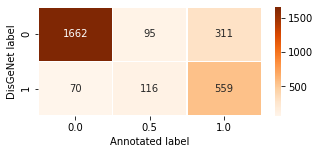

In [308]:
c1, c2 = 'label', 'ann_label'
nc1, nc2 = 'DisGeNet label', 'Annotated label'
tar_s = s_df.groupby([c1, c2])[c2].size()
tar_s.index = tar_s.index.rename([nc1, nc2])

tar_s = tar_s.unstack(level=-1)

fig, ax = plt.subplots(figsize=(5,2)) 
ax = sn.heatmap(tar_s, cmap='Oranges', annot=True, fmt="d", linewidths=.5, ax=ax)

ann_label
0.0    1732
0.5     211
1.0     870
Name: ann_label, dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a6449bfd0>],
      dtype=object)

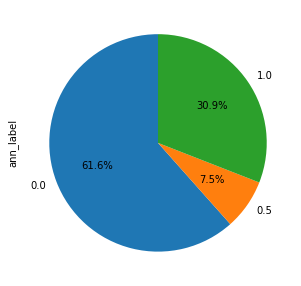

In [309]:
print(s_df.groupby(['ann_label'])['ann_label'].size())
s_df.groupby(['ann_label'])['ann_label'].size().plot(kind='pie', subplots=True, startangle=90,
figsize=(5,5), autopct='%1.1f%%')

In [310]:
# reading 2nd data
raw_data_dir = "../data/ann_table/ann_2nd.tsv"
s_df = pd.read_csv(raw_data_dir, sep='\t', header=0)


In [311]:
s_df['new_label'] = 0.
s_df.loc[pd.isna(s_df['r1_label']), 'new_label'] = s_df[pd.isna(s_df['r1_label'])]['label']
s_df.loc[~pd.isna(s_df['r1_label']), 'new_label'] = s_df[~pd.isna(s_df['r1_label'])]['r1_label']

In [312]:
s_df['ann_label'] = \
s_df.apply(lambda x: 0.5 if (x['new_label'] == 0) and  (x['Have -'] == '1') else x['new_label'], axis=1)

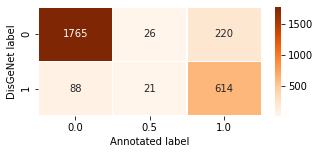

In [317]:
c1, c2 = 'label', 'ann_label'
nc1, nc2 = 'DisGeNet label', 'Annotated label'
tar_s = s_df.groupby([c1, c2])[c2].size()
tar_s.index = tar_s.index.rename([nc1, nc2])

tar_s = tar_s.unstack(level=-1)
fig, ax = plt.subplots(figsize=(5,2)) 
# tar_s = tar_s.transpose()
ax = sn.heatmap(tar_s, cmap='Oranges', annot=True, fmt="d", linewidths=.5, ax=ax)

ann_label
0.0    1853
0.5      47
1.0     834
Name: ann_label, dtype: int64


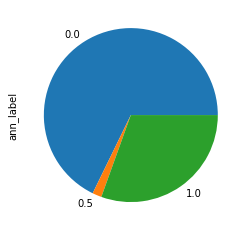

In [194]:
print(s_df.groupby(['ann_label'])['ann_label'].size())
s_df.groupby(['ann_label'])['ann_label'].size().plot(kind='pie')

In [259]:
n1, n2, n3 = 'positivel', 'ambiguous', 'negative'

tar_s1 = s_df1.groupby(['ann_label'])['ann_label'].size()
tar_s1 = tar_s1.rename(index={1: n1, 0.5:n2, 0: n3})
tar_s1 = tar_s1.to_frame()
tar_s1 = tar_s1.rename_axis(None)
tar_s1 = tar_s1.rename(columns={'ann_label': '1st annotated abstract dataset'})

# del tar_s1.index.name

tar_s = s_df.groupby(['ann_label'])['ann_label'].size()
tar_s = tar_s.rename(index={1: n1, 0.5:n2, 0: n3})
tar_s = tar_s.to_frame()
tar_s = tar_s.rename_axis(None)
tar_s = tar_s.rename(columns={'ann_label': '2nd annotated abstract dataset'})


In [264]:
mer_s = tar_s1.merge(tar_s, left_index=True, right_index=True)

In [266]:
mer_s

,1st annotated abstract dataset,2nd annotated abstract dataset
negative,1732,1853
ambiguous,211,47
positivel,870,834


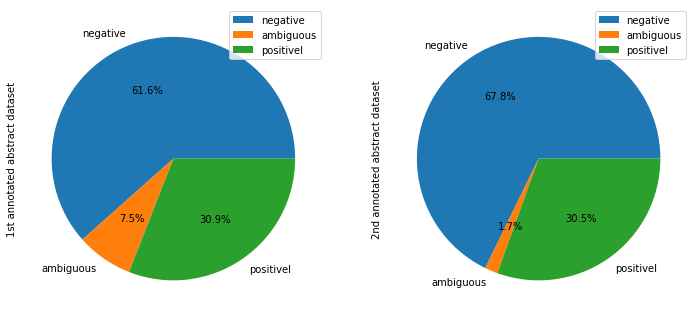

In [284]:
mer_s.plot.pie(subplots=True, figsize=(12, 6), startangle=0,  autopct='%1.1f%%')
plt.show()

In [261]:
tar_s1, tar_s

(           1st annotated abstract dataset
 negative                             1732
 ambiguous                             211
 positivel                             870,
            2nd annotated abstract dataset
 negative                             1853
 ambiguous                              47
 positivel                             834)

/mnt/bal31/jhsu/home/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


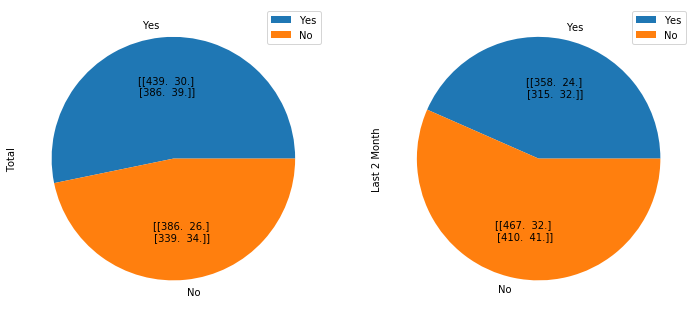

In [214]:
d = {'Yes':pd.Series([825, 56], index=["Total", "Last 2 Month"]), 'No':pd.Series([725, 73], index=["Total", "Last 2 Month"])}
df = pd.DataFrame(d)
df = df.T
def absolute_value(val):
    a  = np.round(val/100.*df.values, 0)
    return a

df.plot.pie(subplots=True, figsize=(12, 6),autopct=absolute_value)
plt.show()

In [215]:
df

,Total,Last 2 Month
Yes,825,56
No,725,73
